# Build CNN with DFG IR

This tutorial illustrates how to construct a CNN by using a framework-independent **Intermediate Representation** (IR) that describes **Data-Flow Graph** (DFG). This IR contains primitives that describe nodes and their connections in the DFG and what operations will these nodes process. Nodes in DFG also carry auxilliary information that directs further optimisation, such as design space exploration. We have a tool that automatically generates DFG IR from the model, which we call **Plumber**.

Through this tutorial, you will learn how we convert the Tensorflow model to DFG IR and understand the specific structure of DFG IR. Next we will walk through the basic syntax of the IR, present how the MNIST is built with the IR can be visualised and verified and show the instructions to train in a TensorFlow back-end. 

This tutorial is organised as follows:
1. [What is Plumber?](#What-is-Plumber?)
2. [Generating DFG IR from Tensorflow Model](#Generating-DFG-IR-from-Tensorflow-Model)
3. [DFG IR Syntax](#DFG-IR-Syntax)
4. [Visualising DFG IR](#Visualising-DFG-IR)
5. [Training using TensorFlow](#Training-using-TensorFlow)
6. [DFG IR and Inference](#DFG-IR-and-Inference)
7. [DFG IR to Tensorflow Model](#DFG-IR-to-Tensorflow-Model)
8. [Exercise](#Exercise)

In [1]:
import tensorflow as tf

## Intended Outcome

1. Learn how to use **Plumber** to convert TensorFlow model into the DFG IR description.
2. Understand the DFG IR syntax
3. Learn how to write a model in DFG IR and train it using TensorFlow

## What is Plumber?

**Plumber** is a tool-chain for generating high-performance FPGA-based CNN inference system. Plumber takes high-level CNN descriptions and training data (in TensorFlow) as input, and outputs an optimised runnable software program together with a hardware design.

This tutorial focuses on the **frontend** part of Plumber, which converts a TensorFlow model into the DFG IR. This IR will be further optimised by the **backend**.

If you have not installed Plumber at thsi point please follow the main README in this repository. 

We have installed Plumber in the JupyterHub environment, you can use it directly. If you intends to run this tutorial on other platforms, please raise your hand to ask for an offline package of our tutorials.

## Generating DFG IR from Tensorflow Model 

Plumber provides a Python module `plumber` and a command-line tool `plumber_cli`. You can use any of them to make use of Plumber utilities.

`gen_dfg` is the specific API to generate DFG IR from a TensorFlow model.The following example first creates a DFG object in memory by `gen_dfg` and then exports its contents into a text file. We use a MNIST LeNet model trained by TensorFlow as an input to `gen_dfg`. The output of this example presents a human-readable format of the MNIST LeNet model written in the DFG IR.

In [2]:
from plumber.utils import gen_dfg

# We have provided a trained model in advance.
dfg = gen_dfg('../data/mnist_model/mnist_lenet.pb', input_image_shape=[1, 28, 28, 1])

# Save the DFG description
dfg.save_dfg_def('../data/mnist_model/mnsit_lenet.pbtxt', is_bin=False)

# Print the human-readable format
dfg.as_dfg_def()

We cannot find "data_format" in the placeholder. We will try to resolve "data_format" in post-process
No need to transpose for layer dense_2/matmul since the rank of its previous layer is 2


name: ""
node {
  name: "img"
  op: "Input"
  device: CPU
  type: T_FLOAT
  input_op_param {
    shape {
      dim: 1
      dim: 1
      dim: 28
      dim: 28
    }
  }
}
node {
  name: "Reshape"
  input: "img"
  op: "Reshape"
  device: CPU
  type: T_FLOAT
  reshape_op_param {
    shape {
      dim: 1
      dim: 1
      dim: 28
      dim: 28
    }
  }
}
node {
  name: "conv2d/conv2d"
  input: "Reshape"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 32
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_maxpool_2x2: false
    use_batch_norm: false
    use_bias: true
    use_relu: true
  }
}
node {
  name: "max_pooling2d/maxpool"
  input: "conv2d/conv2d"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
node {
  name: "conv2d_2/conv2d"
  input: "max_pooling2d/maxpool"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 64
    kernel_size: 5
    pad: 

## DFG IR Syntax
**DFG IR** file structure is very simple, it has a name attribute, and node attribute. 
node can be repeated more than once, but the name has to be unique. 

and more info, you can see [link](https://corerain.github.io/plumber-docs/topics/dfg-ir.html).

For example:
```
name: "test"
node {
  name: "img_input"
  op: "Input"
  device: CPU
  type: T_FLOAT
  input_op_param {
    shape {
      dim: 32 <- Batch size
      dim: 28 <- Height
      dim: 28 <- Width
      dim: 1  <- Number of Channels
    }
  }
}
node {
  name: "conv1"
  input: "img_input"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 32
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_bias: true
  }
}
node {
  name: "pool1"
  input: "conv1"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
node {
  name: "fc3"
  input: "flatten"
  op: "FullyConnected"
  device: CPU
  type: T_FLOAT
  fullyconnected_op_param {
    rows: 1024
    activation_fn: "Relu"
  }
}
```
In node:
- ``name``: Used to specify the name of the node.
- ``op``: Used to specify node's Operation type.
- ``device``: Specifies the execution device for node, such as ``CPU``, ``FPGA``.
- ``type``: Used to specify node's data type.
- ``input``: Used to specify the input of the current node.
- ``shape``: Used to specify the shape of the tensor, the first number is Batch size, then Height, then Width then Number of Channels
- ``xxx_op_param``: is a private parameter of node. It has various parameters that only belong to this op. 
  Its name follows the rules of xxx_op_param, xxx is the lowercase of the node's op value, followed by a fixed format. 
  The exception is ``MaxPool2D``, which is ``max_pool2d_op_param``.

We can also visualize it as a block and later on we will visualize the entire model as a series of blocks. ![block.png](../data/figs/block.png)

### Input Node
```
node {
  name: "img_input"
  op: "Input"
  device: CPU
  type: T_FLOAT
  input_op_param {
    shape {
      dim: 32
      dim: 28
      dim: 28
      dim: 1
    }
  }
}
```
If you want to construct an input like tf.placeholder for Tensorflow:


In [3]:
import tensorflow as tf

# Use TensorFlow
img_input = tf.placeholder(tf.float32, shape=[32, 28, 28, 1], name='img_input')
print("Tensorflow: ", img_input)

Tensorflow:  Tensor("img_input:0", shape=(32, 28, 28, 1), dtype=float32)


In [4]:
# Use Plumber
from plumber.dfg.nodes import DFGInputNode

input_node = DFGInputNode('img_input', shape=[32, 28, 28, 1])
print("DFG IR: ", input_node.tf_api())
print("------------------------------")
print("DFG IR pbtxt")
print(input_node.as_dfg_node_def())

DFG IR:  Tensor("img_input_1:0", shape=(32, 28, 28, 1), dtype=float32)
------------------------------
DFG IR pbtxt
name: "img_input"
op: "Input"
device: CPU
type: T_FLOAT
input_op_param {
  shape {
    dim: 32
    dim: 28
    dim: 28
    dim: 1
  }
}



### Conv2D Node
```
node {
  name: "conv1"
  input: "img_input"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 32
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_bias: true
  }
}
```
- depth: Integer, the dimensionality of the output space.
- kernel_size: Integer, specifying the height and width of the 2D convolution window. We currently only support the same size kernel_size.
- pad: Integer, “valid” is 0, “same” is 1.
- stride: Integer, specifying the strides of the convolution along the height and width. We currently only support the same stride value.
- activation_fn: String, Activate the function name. If it is not needed, fill in the null character.

In [5]:
import tensorflow as tf

# Use TensorFlow
conv1 = tf.layers.conv2d(img_input, 32, 5, padding='same', name="conv1")
print(conv1)

Tensor("conv1/BiasAdd:0", shape=(32, 28, 28, 32), dtype=float32)


In [6]:
# Use Plumber

from plumber.dfg.nodes import DFGConv2DNode

conv1_node = DFGConv2DNode('conv1_1', num_filters=32, kernel_size=5, padding=1, stride=1, activation="Relu")
conv1_node.inputs.append('img_input')
print("DFG IR: ", conv1_node.tf_api(img_input))
print("------------------------------")
print("DFG IR pbtxt")
print(conv1_node.as_dfg_node_def())

DFG IR:  Tensor("conv1_1_1/Relu:0", shape=(32, 28, 28, 32), dtype=float32)
------------------------------
DFG IR pbtxt
name: "conv1_1"
input: "img_input"
op: "Conv2D"
device: CPU
type: T_FLOAT
conv2d_op_param {
  depth: 32
  kernel_size: 5
  pad: 1
  stride: 1
  activation_fn: "Relu"
  use_maxpool_2x2: false
  use_batch_norm: false
  use_bias: false
  use_relu: true
}



### MaxPool2D Node
```
node {
  name: "pool1"
  input: "conv1"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
```

- kernel_size: Integer, (pool_height, pool_width) specifying the size of the pooling window. We currently only support the same size pooling window.
- stride: Integer, specifying the strides of the pooling operation. We currently only support the same stride value.

In [7]:
import tensorflow as tf

# Use TensorFlow
pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2, name='pool1')
print(pool1)

Tensor("pool1/MaxPool:0", shape=(32, 14, 14, 32), dtype=float32)


In [8]:
# Use Plumber

from plumber.dfg.nodes import DFGMaxPoolNode

pool_node = DFGMaxPoolNode('pool1_1', kernel_size=2, stride=2)
pool_node.inputs.append('conv1_1')
print("DFG IR: ", pool_node.tf_api(conv1))
print("------------------------------")
print("DFG IR pbtxt")
print(pool_node.as_dfg_node_def())

DFG IR:  Tensor("pool1_1_1/MaxPool:0", shape=(32, 14, 14, 32), dtype=float32)
------------------------------
DFG IR pbtxt
name: "pool1_1"
input: "conv1_1"
op: "MaxPool2D"
device: CPU
type: T_FLOAT
max_pool2d_op_param {
  kernel_size: 2
  stride: 2
}



### FullyConnected
```
node {
  name: "fc3"
  input: "flatten"
  op: "FullyConnected"
  device: CPU
  type: T_FLOAT
  fullyconnected_op_param {
    rows: 1024
    activation_fn: "Relu"
  }
}
```
- rows: Integer or Long, dimensionality of the output space.
- activation_fn: String, Activate the function name. If it is not needed, fill in the null character.

In [9]:
import tensorflow as tf

# Use TensorFlow
flatten = tf.layers.flatten(pool1)
fc3 = tf.layers.dense(flatten, 1024, activation=tf.nn.relu, name='fc3')
print(fc3)

Tensor("fc3/Relu:0", shape=(32, 1024), dtype=float32)


In [10]:
# Use Plumber

from plumber.dfg.nodes import DFGMatMulNode

fc3_node = DFGMatMulNode('fc3', out_dim=1024, activation='Relu')
fc3_node.inputs.append('pool1_1')
print("DFG IR: ", fc3_node.tf_api(flatten))
print("------------------------------")
print("DFG IR pbtxt")
print(fc3_node.as_dfg_node_def())

DFG IR:  Tensor("fc3_2/Relu:0", shape=(32, 1024), dtype=float32)
------------------------------
DFG IR pbtxt
name: "fc3"
input: "pool1_1"
op: "FullyConnected"
device: CPU
type: T_FLOAT
fullyconnected_op_param {
  rows: 1024
  columns: 0
  batch_size: 1
  activation_fn: "Relu"
  use_relu: true
}



## Visualising DFG IR

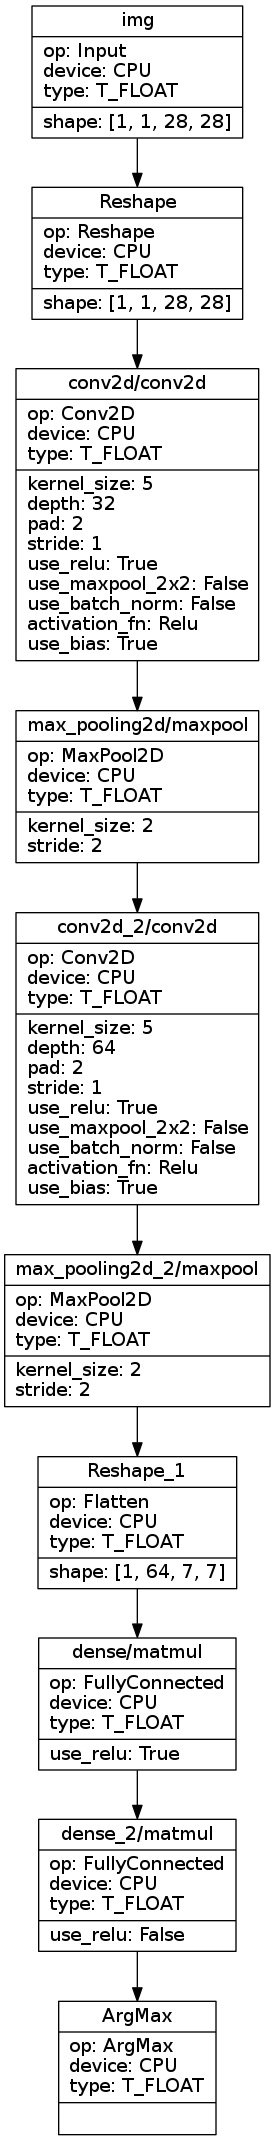

In [11]:
from PIL import Image
from plumber.utils import visualise_dfg

# Generate DFG IR png image
visualise_dfg('../data/mnist_model/mnist_lenet.pbtxt', '../data/mnist_model/mnist_lenet.png')

im = Image.open('../data/mnist_model/mnist_lenet.png')
# show
im

## Training using TensorFlow

A model written in the DFG IR can be trained by TensorFlow through Plumber. Plumber provides an easy-to-use API, `dfg_to_tf`, to convert DFG IR back to a TensorFlow graph.

The following example presents how to load a DFG and then convert it to a TensorFlow `Graph`. `dfg_to_tf` accepts a DFG file name and a TensorFlow `Graph` object. It populates the contents from the given DFG file to the empty TensorFlow `Graph`. Most of the nodes in the DFG will be converted to `Tensor`s with identical names. You can further wrap the returned graph into a training utility.

**WARNING**: the training code block is just for demonstration, please don't directly run it in the JupyterHub since our resources are limited.

In [12]:
with open('../data/mnist.pbtxt', 'r') as f:
    print(f.read())

name: "CNN_MNIST"
node {
  name: "img_input"
  op: "Input"
  device: CPU
  type: T_FLOAT
  input_op_param {
    shape {
      dim: 50
      dim: 28
      dim: 28
      dim: 1
    }
  }
}
node {
  name: "conv1"
  input: "img_input"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 32
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_bias: true
  }
}
node {
  name: "pool1"
  input: "conv1"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
node {
  name: "conv2"
  input: "pool1"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 64
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_bias: true
  }
}
node {
  name: "pool2"
  input: "conv2"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
node {
  name: "flatten"
  input: "pool2"
  op: "Flatten"
  device: CPU
  type:

## DFG IR and Inference

Each model has a calculation graph structure, which is the model's Inference.

In tensorflow, the inference of mnist is like this:

```python
def lenet(images, keep_prob):
    """
    Args:
        images: a 4-D tensor that holds batched input images
    Return:
        A tensor that contains classification probabilities result, and a dictionary
        of all intermediate tensors.
    """    
    end_points = {}
    end_points['images'] = tf.reshape(images, [-1, 28, 28, 1])

    with tf.variable_scope('conv1'):
        w1 = tf.get_variable('weights', [5, 5, 1, 32])
        b1 = tf.get_variable('biases', [32],
                             initializer=tf.zeros_initializer())
        end_points['conv1'] = tf.nn.relu(
            tf.nn.conv2d(end_points['images'], w1, [1, 1, 1, 1], 'SAME') + b1)
    end_points['pool1'] = tf.nn.max_pool(
        end_points['conv1'], [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    with tf.variable_scope('conv2'):
        w2 = tf.get_variable('weights', [5, 5, 32, 64])
        b2 = tf.get_variable('biases', [64],
                             initializer=tf.zeros_initializer())
        end_points['conv2'] = tf.nn.relu(
            tf.nn.conv2d(end_points['pool1'], w2, [1, 1, 1, 1], 'SAME') + b2)
    end_points['pool2'] = tf.nn.max_pool(
        end_points['conv2'], [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    end_points['flatten'] = tf.reshape(end_points['pool2'], [-1, 7 * 7 * 64])
    with tf.variable_scope('fc3'):
        w3 = tf.get_variable('weights', [7 * 7 * 64, 1024])
        b3 = tf.get_variable('biases', [1024],
                             initializer=tf.zeros_initializer())
        end_points['fc3'] = tf.nn.relu(tf.matmul(end_points['flatten'], w3) + b3)
        
    end_points['dropout'] = tf.nn.dropout(end_points['fc3'], keep_prob)
    with tf.variable_scope('fc4'):
        w4 = tf.get_variable('weights', [1024, 10])
        b4 = tf.get_variable('biases', [10],
                             initializer=tf.zeros_initializer())
        end_points['fc4'] = tf.matmul(end_points['fc3'], w4) + b4
    
    return end_points['fc4'], end_points
```

DFG IR can also be used as a lite version of the model Inference，So they are reversible, DFG IR can be obtained from Inference, and a trainable model can be obtained from DFG IR.

Next, let's take a look at using DFG IR to train the model.

## DFG IR to Tensorflow Model

Plumber provides an api that converts a DFG IR file mnist.pbtxt into a Tensorflow graph. it calls `dfg_to_tf`.

```
def dfg_to_tf(dfg_file, graph, inputs=None, outputs=None, is_training=True):
    pass
```

- dfg_file: such as mnist.pbtxt.
- graph: a tf.Graph() object.
- inputs: a Tensor object.
- outputs: a Dict object.
- is_training: Same as tensorflow.

Because our DFG IR only provides an input node in one format, In order to provide more flexibility, we can define the input node in DFG IR, and then pass in the inputs parameter, then `Input` in DFG IR is equivalent to the role of `placeholder`.

NOTE：But in MNIST, using `Input` is enough.

In [1]:
from plumber.utils import dfg_to_tf

# We use pbtxt to load the model and get a graph that defines the network model

graph = tf.Graph()
graph, output_nodes = dfg_to_tf('../data/mnist.pbtxt', graph)

images = graph.get_tensor_by_name("img_input:0")
print(images)

logits = output_nodes['cls_output_node']
print(logits)

ModuleNotFoundError: No module named 'plumber'

In [2]:
# Due to server resource issues, please try this on your own computer
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../data/MNIST_data/", one_hot=True)

# Graph is a network diagram generated using Plumebr
with graph.as_default():
    labels = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    
    # Nodes for training
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
    train = tf.train.AdadeltaOptimizer(1e-3).minimize(loss)
    
    # accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()
    
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(20000):
            batch_xs, batch_ys = mnist.train.next_batch(50)
            imgs = batch_xs.reshape((50, 28, 28, 1))
            _, loss_val = sess.run([train, loss],
                                   feed_dict={images: imgs,
                                              labels: batch_ys,
                                              keep_prob: 0.5})
        
            if i % 100 == 0:
                print('Loss value of a training batch at step %5d: %f' % (i, np.mean(loss_val)))
            if i % 1000 == 0:
                batch_x_test, batch_y_test = mnist.train.next_batch(50)
                acc = sess.run(accuracy,
                               feed_dict={images: batch_x_test.reshape((50, 28, 28, 1)),
                                          labels: batch_y_test,
                                          keep_prob: 1.0})
                print('Accuracy after running %5d steps: %f' % (i, acc))
        total_acc = 0
        for i in range(200):
            batch_x_test, batch_y_test = mnist.train.next_batch(50)
            acc = sess.run(accuracy,
                           feed_dict={images: batch_x_test.reshape((50, 28, 28, 1)),
                                      labels: batch_y_test,
                                      keep_prob: 1.0})
            total_acc += acc
        print('Accuracy after running 20000 steps: %f' % (total_acc/200))
        # save the trained model
        saver.save(sess, "mnist_lenet_logs/mnist_net.ckpt")

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Loss value of a training batch at step     0: 2.286170
Accuracy after running     0 steps: 0.140000
Loss value of a training batch at step   100: 2.286594
Loss value of a training batch at step   200: 2.286906
Loss value of a training batch at step   300: 2.279326
Loss value of a training batch at step   400: 2.270366
Loss value of a training batch at step   500: 2.266109
Loss value of a training batch at step   600: 2.240665
Loss value of a training batch at step   700: 2.251173
Loss value of a training batch at step   800: 2.233912
Loss value of a training batch at step   900: 2.216084
Loss value of a training batch at step  1000: 2.217929
Accuracy after running  1000 steps: 0.420000
Loss value of a training batch at step  1100: 2.205479
Loss value of a training

Loss value of a training batch at step 13400: 0.672461
Loss value of a training batch at step 13500: 0.742156
Loss value of a training batch at step 13600: 0.575663
Loss value of a training batch at step 13700: 0.703015
Loss value of a training batch at step 13800: 0.575930
Loss value of a training batch at step 13900: 0.629517
Loss value of a training batch at step 14000: 0.709459
Accuracy after running 14000 steps: 0.840000
Loss value of a training batch at step 14100: 0.675367
Loss value of a training batch at step 14200: 0.600971
Loss value of a training batch at step 14300: 0.511204
Loss value of a training batch at step 14400: 0.564078
Loss value of a training batch at step 14500: 0.547255
Loss value of a training batch at step 14600: 0.576333
Loss value of a training batch at step 14700: 0.456705
Loss value of a training batch at step 14800: 0.656424
Loss value of a training batch at step 14900: 0.611884
Loss value of a training batch at step 15000: 0.655859
Accuracy after runni

# Exercise 

We have prepared an exercise for you. You can define a CIFAR-10 model by using the DFG IR syntax, and visualize it. Try and and train the model.

About CIFAR-10, see [tensorflow-model-cifar10](https://github.com/tensorflow/models/tree/master/tutorials/image/cifar10)

There are some new nodes here.

LRN Node:

```
name: "norm1"
input: "conv1"
op: "LRN"
device: CPU
type: T_FLOAT
lrn_op_param {
  depth_radius: 5
  bias: 1.0
  alpha: 1.0
  beta: 0.5
}
```

- depth_radius: An optional int. Defaults to 5. 0-D. Half-width of the 1-D normalization window.
- bias: An optional float. Defaults to 1. An offset (usually positive to avoid dividing by 0).
- alpha: An optional float. Defaults to 1. A scale factor, usually positive.
- beta: An optional float. Defaults to 0.5. An exponent.

Flatten Node:

```
node {
  name: "flatten"
  input: "pool1"
  op: "Flatten"
  device: CPU
  type: T_FLOAT
}
```
No special parameters are needed, you only need to define its input.

You should finish the following tasks:

1. Defining the CIFAR-10 model structure using DFG IR.
2. Visualize your DFG IR with Plumber.
3. Use DFG IR for training, optional.

Note: The answer is in the Answer folder.